In [1]:
# Import libraries and initialize global variables
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
Start_date = utils.date_range()[0]
End_date = utils.date_range()[1]
import datetime 
  
def convert2hours(n): 
    return str(datetime.timedelta(seconds = n)) 

In [2]:
# Pick start date
Start_date

DatePicker(value=datetime.date(2020, 9, 22), description='Start Date')

In [3]:
# Pick end date
End_date

DatePicker(value=datetime.datetime(2021, 2, 19, 12, 10, 25, 626555), description='End Date')

In [4]:
%%time
# database response stored in pandas dataframe
df = utils.db_connect(pem_file='centos.pem',
                      start_date=Start_date.value.strftime("%Y-%m-%d"),
                      end_date=End_date.value.strftime("%Y-%m-%d"))

CPU times: user 13.6 s, sys: 4.06 s, total: 17.7 s
Wall time: 39.4 s


In [ ]:
df['device_deployed'] = np.where(df['mac'].isin(['84CCA89A1706','84CCA899CEE53','CC50E304FA9A',
                   '84CCA899FCA7','84CCA89B799C','CC50E3DA533F']), 'Yes', 'No')

In [19]:
# Filter out devices that are not deployed
df['device_deployed'] = np.where(df['mac'].isin(['84CCA89A1706','84CCA899CEE53','CC50E304FA9A',
                   '84CCA899FCA7','84CCA89B799C','CC50E3DA533F']), 'Yes', 'No')
df = df[df.device_deployed=='Yes']
df.tail()

,id,status,userid,timestamp,mac,current,voltage,power,devicestatus,device_deployed
408637,408638,1,505,2021-02-19 16:06:56,CC50E3DA533F,0.48,209,91.82,on,Yes
408638,408639,1,505,2021-02-19 16:07:26,CC50E3DA533F,0.48,206,91.18,on,Yes
408639,408640,1,505,2021-02-19 16:07:56,CC50E3DA533F,0.48,207,91.29,on,Yes
408640,408641,1,505,2021-02-19 16:08:27,CC50E3DA533F,0.48,210,91.59,on,Yes
408641,408642,1,505,2021-02-19 16:08:56,CC50E3DA533F,0.48,205,90.9,on,Yes


In [22]:
# Number of unique mac ids
df.mac.unique()

array(['CC50E304FA9A', 'CC50E3DA533F', '84CCA89A1706', '84CCA89B799C',
       '84CCA899FCA7'], dtype=object)

In [23]:
# Change column types to numeric
df[["current","voltage", "power"]] = df[["current","voltage", "power"]].apply(pd.to_numeric)

In [25]:
# Add date range filter
start_date = '2020-12-05'
end_date = '2020-12-06'
date_mask = (df['timestamp'] > start_date ) & (df['timestamp'] <= end_date)
df_with_mask = df.loc[date_mask]
# Select a specific mac address
df_mac1 = df_with_mask[df_with_mask['mac'].isin(["CC50E3DA533F"])]

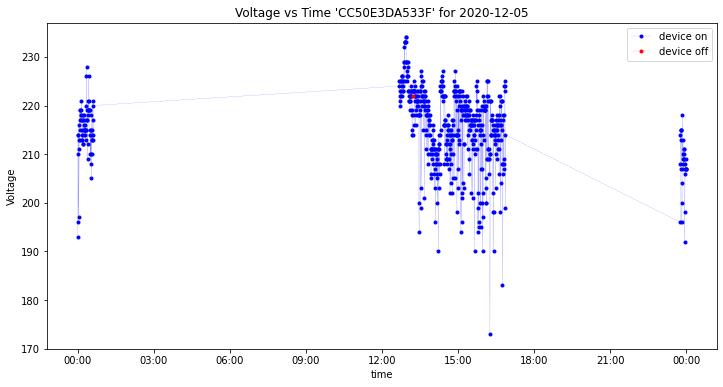

In [26]:
# Plot for Voltage vs Time CC50E3DA533F
fig, ax = plt.subplots(1,1,figsize=(12,6))
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
ax.plot(on["timestamp"], on["voltage"], 'b.-', lw=0.1, label='device on')
ax.plot(off["timestamp"], off["voltage"], 'r.-', lw=0.1,label='device off')

ax.set_title(f'Voltage vs Time \'CC50E3DA533F\' for {start_date}')
ax.set_xlabel('time')
ax.set_ylabel('Voltage')
ax.legend()


myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
ax.xaxis.set_major_formatter(myFmt)
plt.show()

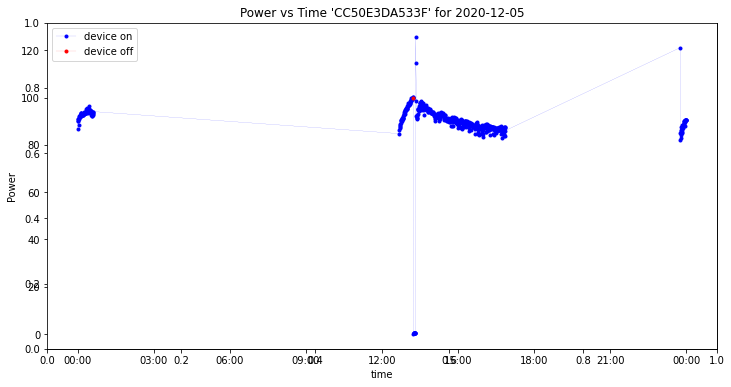

In [30]:
# Plot for Power vs Time CC50E3DA533F
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = fig.add_subplot(111)
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
ax.plot(on["timestamp"], on["power"], 'b.-', lw=0.1, label='device on')
ax.plot(off["timestamp"], off["power"], 'r.-', lw=0.1,label='device off')
ax.set_title(f'Power vs Time \'CC50E3DA533F\' for {start_date}')
ax.set_xlabel('time')
ax.set_ylabel('Power')
plt.legend()
myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [32]:
## groupby mac addresses
df_grouped_mac = df.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
df_grouped_mac['duration'] = df_grouped_mac.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as no data received
df_grouped_mac.loc[df_grouped_mac['duration'] >=60, 'devicestatus'] = 'no_data_received' # setting a timeout threshold

In [36]:
## groupby mac addresses
df_grouped_mac = df.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
df_grouped_mac['duration'] = df_grouped_mac.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as no data received
df_grouped_mac.loc[df_grouped_mac['duration'] >=60, 'devicestatus'] = 'no_data_received' # setting a timeout threshold

## Apply filters
mac_address = ['CC50E3DA533F','CC50E304FA9A'] # select these mac addresses
date = ['2020-09-23'] # select these dates
tmp = df_grouped_mac.groupby(['mac','date','devicestatus'])['duration'].sum().reset_index()
tmp['duration_in_hours'] = tmp['duration'].apply(convert2hours)
tmp[tmp['mac'].isin(mac_address) & tmp['date'].isin(date)]

,mac,date,devicestatus,duration,duration_in_hours
124,CC50E304FA9A,2020-09-23,no_data_received,3604.0,1:00:04
125,CC50E304FA9A,2020-09-23,on,40572.0,11:16:12
217,CC50E3DA533F,2020-09-23,no_data_received,5684.0,1:34:44
218,CC50E3DA533F,2020-09-23,off,238.0,0:03:58
219,CC50E3DA533F,2020-09-23,on,80441.0,22:20:41
